# Merge ontology PMA
In this notebook I make a version of the Princeton Mouse atlas annotation volume and corresponding csv file where the parents always have lower ids than the children. I then show how to integrate python API key bindings for using segment equivalences to collapse/expand the PMA regions in Neuroglancer. 

This notebook makes heavy use of the file PMA_ontology.json which was created in a different notebook: [Create_PMA_ontology_JSON.ipynb](Create_PMA_ontology_JSON.ipynb) and now lives on bucket.

In [2]:
import neuroglancer
import json, csv
import numpy as np
import graphviz
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import copy
from multiprocessing import Pool #  Process pool
from multiprocessing import sharedctypes
%matplotlib inline  

In [3]:
annotation_vol_filename_orig = '/home/ahoag/ngdemo/data/princeton_mouse_atlas/annotation_sagittal_atlas_20um_iso.tif'
annotation_vol_orig = np.array(tifffile.imread(annotation_vol_filename_orig),dtype='uint32')

In [4]:
annotation_vol_orig.dtype

dtype('uint32')

In [5]:
df_filename = '/home/ahoag/ngdemo/data/princeton_mouse_atlas/Princeton_mouse_atlas_id_table_public.csv'
df_pma = pd.read_csv(df_filename)
ids=df_pma['id']
names = df_pma['name']
ss_id_dict = {ids[ii]:names[ii] for ii in range(len(df_pma))}
ss_name_dict = {names[ii]:ids[ii] for ii in range(len(df_pma))}
df_pma

,name,acronym,id,parent_structure_id,parent_name,parent_acronym,voxels_in_structure
0,"Tuberomammillary nucleus, ventral part",TMv,1,557.0,Tuberomammillary nucleus,TM,13542
1,"Primary somatosensory area, mouth, layer 6b",SSp-m6b,2,345.0,"Primary somatosensory area, mouth",SSp-m,9621
2,secondary fissure,sec,3,1040.0,grooves of the cerebellar cortex,grv of CBX,0
3,Inferior colliculus,IC,4,339.0,"Midbrain, sensory related",MBsen,22705
4,internal capsule,int,6,784.0,corticospinal tract,cst,176771
...,...,...,...,...,...,...,...
1325,"Interpeduncular nucleus, intermediate",IPI,607344850,100.0,Interpeduncular nucleus,IPN,0
1326,"Interpeduncular nucleus, dorsomedial",IPDM,607344854,100.0,Interpeduncular nucleus,IPN,0
1327,"Interpeduncular nucleus, dorsolateral",IPDL,607344858,100.0,Interpeduncular nucleus,IPN,0
1328,"Interpeduncular nucleus, rostrolateral",IPRL,607344862,100.0,Interpeduncular nucleus,IPN,0


In [6]:
ontology_file = '/home/ahoag/ngdemo/data/princeton_mouse_atlas/PMA_ontology.json'

with open(ontology_file) as json_file:
    data = json.load(json_file)

In [7]:
data

{'id': 997,
 'name': 'root',
 'graph_order': 0,
 'parent_structure_id': None,
 'children': [{'id': 8,
   'name': 'Basic cell groups and regions',
   'acronym': 'grey',
   'parent_structure_id': 997,
   'graph_order': 1,
   'children': [{'id': 343,
     'name': 'Brain stem',
     'acronym': 'BS',
     'parent_structure_id': 8,
     'graph_order': 2,
     'children': [{'id': 313,
       'name': 'Midbrain',
       'acronym': 'MB',
       'parent_structure_id': 343,
       'graph_order': 3,
       'children': [{'id': 323,
         'name': 'Midbrain, motor related',
         'acronym': 'MBmot',
         'parent_structure_id': 313,
         'graph_order': 4,
         'children': [{'id': 35,
           'name': 'Oculomotor nucleus',
           'acronym': 'III',
           'parent_structure_id': 323,
           'graph_order': 5,
           'children': []},
          {'id': 58,
           'name': 'Medial terminal nucleus of the accessory optic tract',
           'acronym': 'MT',
           'pare

In [8]:
# Now we need to make a graph of all these connections
# and while we're at it we can make the dictionary 
# that maps old ID to new ID so that parents
# always have lower IDs than children
# Also want to make a dictionary mapping new id to full region name
new_dic = {} # maps old ID to new ID
region_fullname_dict = {} # maps new ID to full name of region, i.e. acronym + name
ontology_id_dict = {} # maps new ID to name of region
def make_id_graph(dic,graph=None):
    """ Make a directed graph from a dictionary
    Representing a brain ontology
    """
    if not graph:
        graph = graphviz.Digraph()
    name = dic.get('name')
    acronym = dic.get('acronym')
    children = dic.get('children')
    orig_id = dic.get('id')
    new_id = dic.get('graph_order') + 1
    new_dic[orig_id] = new_id
    region_fullname = f'{acronym}: {name}'
    region_fullname_dict[new_id] = region_fullname
    ontology_id_dict[new_id] = name
    graph.node(name,f'{acronym}: {new_id}')
    for child in children:
        child_name = child.get('name')
        graph.edge(name,child_name)
        make_id_graph(child,graph)
    return graph


Gnew = make_id_graph(dic=data)

In [9]:
new_dic

{997: 1,
 8: 2,
 343: 3,
 313: 4,
 323: 5,
 35: 6,
 58: 7,
 66: 8,
 75: 9,
 115: 10,
 128: 11,
 539: 12,
 548: 13,
 555: 14,
 214: 15,
 231: 16,
 246: 17,
 294: 18,
 10: 19,
 494: 20,
 503: 21,
 511: 22,
 17: 23,
 26: 24,
 42: 25,
 381: 26,
 615: 27,
 616: 28,
 749: 29,
 757: 30,
 795: 31,
 50: 32,
 67: 33,
 587: 34,
 614454272: 35,
 975: 36,
 1100: 37,
 215: 38,
 531: 39,
 628: 40,
 634: 41,
 706: 42,
 1061: 43,
 549009203: 44,
 549009207: 45,
 549009211: 46,
 606826688: 47,
 607344830: 48,
 339: 49,
 4: 50,
 811: 51,
 820: 52,
 828: 53,
 271: 54,
 302: 55,
 834: 56,
 842: 57,
 851: 58,
 460: 59,
 580: 60,
 874: 61,
 599626944: 62,
 348: 63,
 165: 64,
 12: 65,
 100: 66,
 607344834: 67,
 607344838: 68,
 607344842: 69,
 607344846: 70,
 607344850: 71,
 607344854: 72,
 607344858: 73,
 607344862: 74,
 197: 75,
 591: 76,
 872: 77,
 374: 78,
 1052: 79,
 1065: 80,
 354: 81,
 370: 82,
 76: 83,
 83: 84,
 106: 85,
 135: 86,
 143: 87,
 939: 88,
 136: 89,
 154: 90,
 161: 91,
 169: 92,
 177: 93,
 2

In [10]:
# Initialize a new 16-bit volume 
new_vol = np.zeros_like(annotation_vol_orig,dtype='uint16')
np.shape(new_vol)

(540, 640, 352)

In [11]:
new_vol.dtype

dtype('uint16')

In [16]:
segments_32bit = np.unique(annotation_vol_orig)
# Remove the zero element
segments_32bit = [x for x in segments_32bit if x!=0]

In [17]:
len(segments_32bit)

629

In [18]:
# Let's check to see if there are any regions in the volume that are not in the graph. 
for segment_32bit in segments_32bit:
    if segment_32bit not in new_dic.keys():
        print(segment_32bit)

We are not missing any!

Can proceed with the relabeling. We will do this in parallel.

In [19]:
def id_reassignment_parallel(list_of_tuples):
    '''
    ---PURPOSE---
    Set masked region in one image to an integer value in another image
    using a shared array to make parallel assignment possible
    ---INPUT---
    list_of_tuples, like: [(input_val,target_val),(),...], where:
        input_val        The value of the int you want to convert 
        target_val       The value you want input_val to be converted to
    '''
    tmp = np.ctypeslib.as_array(shared_array)
    for tup in list_of_tuples:        
        input_val,target_val = tup
        mask = (annotation_vol_orig == input_val)
        tmp[mask] = target_val
    return

In [20]:
%%time
# Fill out the new annotation volume in parallel
# I explored different chunk sizes in range from 5-50 and ~10 was optimal.
# This is faster than doing this without parallel processing by a factor of ~5
# On my desktop which has 12 cores
chunk_size=10 # number of IDs to reassign in each parallel process. 
X = new_vol.copy()
# print(chunked_list_of_tuples)
list_of_tuples = [(key,new_dic[key]) for key in segments_32bit]
chunked_list_of_tuples = [list_of_tuples[i:i+chunk_size] for i in range(0,len(list_of_tuples),chunk_size)]
n_chunks = len(chunked_list_of_tuples)
print(f"Have {n_chunks} chunks of tuples, with {chunk_size} tuples in each chunk")
result = np.ctypeslib.as_ctypes(X)
shared_array = sharedctypes.RawArray(result._type_, result)
with Pool() as p: # use all available cores. 
    res = p.map(id_reassignment_parallel,chunked_list_of_tuples)
    result_new = np.ctypeslib.as_array(shared_array)

Have 63 chunks of tuples, with 10 tuples in each chunk
CPU times: user 168 ms, sys: 380 ms, total: 548 ms
Wall time: 12.6 s


In [21]:
np.count_nonzero(result_new) # should be > 0 !

49032397

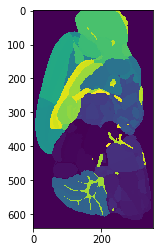

In [22]:
plt.imshow(result_new[228])

Now check that the new volume's area where a known region is defined actually shows up in the right place

In [23]:
ss_name_dict['Main olfactory bulb']

507

In [24]:
new_dic[507]

927

In [25]:
olfactory_mask = result_new == new_dic[ss_name_dict['Main olfactory bulb']]

In [26]:
len(result_new[olfactory_mask])

1560591

In [27]:
# Clearly has voxels, let's check:

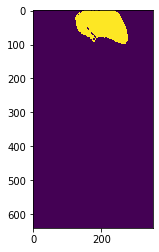

In [28]:
plt.imshow(olfactory_mask[228])

Looks good.

OK, now let's save this tiff volume.

## Save tiff volume

In [31]:
new_vol = result_new.copy().astype('uint16')

In [32]:
new_vol.dtype

dtype('uint16')

In [33]:
new_vol.shape

(540, 640, 352)

In [34]:
filename = '/home/ahoag/ngdemo/data/princeton_mouse_atlas/annotation_sagittal_atlas_20um_16bit_hierarch_labels.tif'
tifffile.imsave(filename,result_new)

## Save the segment properties file for this new volume

In [ ]:
segment_props_dict = {"@type": "neuroglancer_segment_properties",
    "inline": {"ids": [],
               "properties":[{"id": "label", "type": "label", "values":
                              []}]}}

In [ ]:
# To do this, I will need a dictionary mapping the new ids to their full region names,
# e.g. "2: grey: Basic cell groups and regions"

In [ ]:
segment_props_dict['inline']['ids'] = [str(x) for x in region_fullname_dict.keys()]

In [ ]:
segment_props_dict['inline']['properties'][0]['values'] = [str(x) for x in region_fullname_dict.values()]

In [ ]:
segment_props_dict

In [ ]:
filename = '/home/ahoag/ngdemo/demo_bucket/atlas/princetonmouse_16bit_hierarch_labels/segment_properties/info'
with open(filename,'w') as outfile:
    json.dump(segment_props_dict,outfile,indent=2)

## Merge ontology feature
Here we will try to introduce a key that will use the segment properties mapping to collapse a segment you are hovering over to its parent region, along with all children of the same parent.

In [ ]:
# some helper graph functions
def get_progeny(dic,input_nodename,progeny_list=None):
    """
    Gets all of the descendents of a given input nodename.
    --- INPUT ---
    dic             The dictionary representing the JSON ontology graph
    input_nodename   The name of the region whose progeny you want to know
    """
    if progeny_list == None:
        progeny_list = []
    if input_nodename == 'root':
        return list(ontology_name_dict.keys()) 
        
    name = dic.get('name')

    children = dic.get('children')
    if name == input_nodename:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,input_nodename=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,input_nodename=input_nodename,progeny_list=progeny_list)
    return progeny_list

def get_parent(graph,input_nodename):
    if len(input_nodename.split(' ')) > 1:
        nodename_to_search = f'"{input_nodename}"'
    else:
        nodename_to_search = input_nodename
    edges_pointing_to_node=[x for x in graph.body if f'-> {nodename_to_search}' in x]
    if len(edges_pointing_to_node) == 0:
        return None
    elif len(edges_pointing_to_node) > 1:
        print("Error. There should not be more than one edge pointing to this node")
    else:
        parent_nodename = edges_pointing_to_node[0].split('->')[0].strip()
        # remove the extra quotes surrounding the nodename if there is more than one word
        if len(parent_nodename.split(' ')) > 1:
            return parent_nodename[1:-1]
        else:
            return parent_nodename
    return

In [ ]:
get_parent(Gnew,"Cerebrum")

In [ ]:
progeny_list=get_progeny(data,input_nodename='Medial group of the dorsal thalamus')
progeny_list

In [ ]:
# For the atlas ontology tools we will also need a dictionary mapping region names to new ids
names = list(ontology_id_dict.values())
new_ids = list(ontology_id_dict.keys())
ontology_name_dict = {names[ii]:new_ids[ii] for ii in range(len(names))}

In [ ]:
ontology_name_dict

In [ ]:
ontology_id_dict[1260]

In [ ]:
ontology_id_dict[1261]

In [ ]:
def init_tool(s):
    print("in init_tool()")
    with viewer.config_state.txn() as st:
        try:
            del st.status_messages['hello']
        except KeyError:
            pass
    print("made it here")
    """ first figure out the selected layer """
    with viewer.txn() as txn:
        if len(txn.layers) > 1:
            selected_layer_name = txn.selectedLayer.layer
            if not selected_layer_name:
                with viewer.config_state.txn() as st:
                    st.status_messages['hello'] = 'No layer selected. Select a layer (right click or ctrl+click the layer panel)'        
                    return None, None
        elif len(txn.layers) == 1:
            print("should be here")
            selected_layer_name = txn.layers[0].name
        else:
            with viewer.config_state.txn() as st:
                st.status_messages['hello'] = 'No layers loaded. First load a layer to use this tool'        
                return None, None
    print("selecting region_map")
    print("layer name:")
    print(selected_layer_name)
    print("selected values:")
    print(s.selected_values)
    try:
        region_map = s.selected_values[selected_layer_name]
    except KeyError:
        # you need to move your cursor to get the layer to be selectable again
        return None, None
    named_tuple = region_map.value
    print("end of init_tool()")
    print("named tuple:")
    print(named_tuple)
    return named_tuple, selected_layer_name

def contract_atlas(s):
    named_tuple, selected_layer_name = init_tool(s)
    if not selected_layer_name:
        return
    if named_tuple:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'key p pressed: contracting atlas' 
        if named_tuple.value:
            region_id = named_tuple.value
        else:
            region_id = named_tuple.key
        region_name = ontology_id_dict[region_id]
        # Look up parent name and then get corresponding ID
        parent_name = get_parent(Gnew,region_name)
        if not parent_name:
            with viewer.config_state.txn() as st:
                st.status_messages['hello'] = 'No parent found.'
            return
        parent_id = ontology_name_dict.get(parent_name)
        print(parent_id,parent_name)
        # find all progeny of this parent
        progeny_list = get_progeny(data,input_nodename=parent_name) # progeny names
        print(progeny_list)
        # initialize our equivalence list using the id-parent relationship we just found
        equivalence_list = [] 
        # Get the progeny ids and include them in the equivalence list
        for progeny_name in progeny_list:
            progeny_id = ontology_name_dict.get(progeny_name)
            if progeny_id:
                equivalence_list.append((progeny_id,parent_id)) 
        with viewer.txn() as txn:
            existing_equivalences = list(txn.layers[selected_layer_name].layer.equivalences.items())
            final_equivalence_list = existing_equivalences + equivalence_list
            txn.layers[selected_layer_name].layer.equivalences = final_equivalence_list
        return
    else:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'No segment under cursor. Hover over segment to enable hierarchy tools' 
        return
    
def expand_atlas(s):
    named_tuple, selected_layer_name = init_tool(s)
    if not selected_layer_name:
        return
    
    if named_tuple:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'key c pressed: expanding atlas' 
        """ if the hovered segment is mapped to a parent, then start at the parent level"""
        if named_tuple.value:
            region_id = named_tuple.value
        else:
            region_id = named_tuple.key
        """ Find and remove any existing equivalences that involve this region_id"""
        with viewer.txn() as txn:
            equiv_map = txn.layers[selected_layer_name].layer.equivalences
            if region_id not in equiv_map.keys():
                with viewer.config_state.txn() as st:
                    st.status_messages['hello'] = 'This segment is already at the lowest level in the hierarchy'
            else:
                equiv_map.delete_set(region_id)
        return
    else:
        with viewer.config_state.txn() as st:
            st.status_messages['hello'] = 'No segment under cursor. Hover over segment to enable hierarchy tools' 
        return

In [ ]:
# key binding to merge segment with its parent segment using the ontology
def add_key_bindings():
    index = np.random.randint(0,100000)
    viewer.actions.add(f'contract-atlas{index}', contract_atlas)
    viewer.actions.add(f'expand-atlas{index}', expand_atlas)
    with viewer.config_state.txn() as s:
        s.input_event_bindings.viewer['keyp'] = f'contract-atlas{index}'
        s.input_event_bindings.viewer['keyc'] = f'expand-atlas{index}'
        s.status_messages['hello'] = 'Welcome to the merge ontology example. Press p to go up a level, c to go down a level.'


In [ ]:
# neuroglancer.set_static_content_source(url='https://nglancer.pni.princeton.edu')
neuroglancer.set_static_content_source(url='http://localhost:8080')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.layers['PMA hierarch labels'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1339'
    )
print(viewer)

In [ ]:
add_key_bindings()